# **Importing Libraries**  📚

In [1]:
SEED=42
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# Categorical attribute conversion to numeric
from sklearn.preprocessing import OrdinalEncoder

# Data Imputer
from sklearn.impute import SimpleImputer

# Model Selection
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

# Accuracy Metrics
from sklearn.metrics import accuracy_score


# Model library
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

In [2]:
df_train = pd.read_csv("../input/titanic/train.csv")
df_test  = pd.read_csv("../input/titanic/test.csv")
df = [df_train, df_test]

# Creating a copy of test dataset for final submission 
df_test_copy = df_test  

In [3]:
# Taking a look at the dataframe shape
print("Train dataset has {} rows & {} columns ".format(df_train.shape[0], df_train.shape[1]))
print("Test dataset has {} rows & {} columns ".format(df_test.shape[0], df_test.shape[1]))

Train dataset has 891 rows & 12 columns 
Test dataset has 418 rows & 11 columns 


A quick analysis of train dataset using info() function on training dataset will give clear picture of the dataframe. Training dataset has 12 columns out of which Name, Sex, Cabin and Embarked features have object type Dtype, which we will have to take care during data encoding step.  Also Age, Cabin and Embarked features have missing values

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Lets explore each feature of the dataset and check if particular dataset is contributing any significant inforamtion for the model.

# **Analysis of Each Feature Column**

# 1. PassengerId


This column has unique ID details of the passengers which has no effect on the survival of a passenger.

# 2. Survived


Target column which has values 0 and 1 for all passengers who survived and not survived respectively.

# 3. Pclass


Boarding class of each passenger. First task is to check unique values in the Pclass and any NaN value.

In [6]:
#unique value in the Pclass attribute
df_train['Pclass'].unique()

array([3, 1, 2])

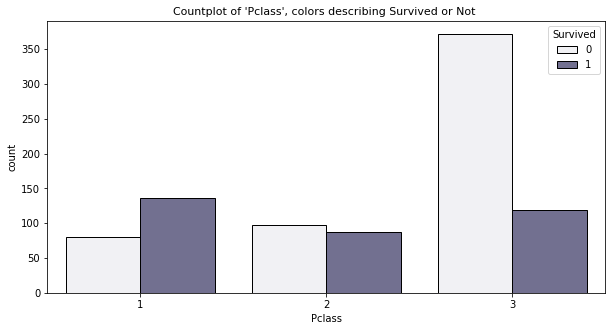

In [7]:
#Visualization of Pclass column
plt.figure(figsize=(10,5))
plt.title("Countplot of 'Pclass', colors describing Survived or Not ", size=11)
sns.countplot(data=df_train, x='Pclass', hue='Survived', color='#6E6B95', edgecolor='black')
plt.show()

# 4. Name


Name attribute describes the name of the passenger, which does not have affect on the survival of any person.

# 5. Sex


Sex column has no missing and NaN value and has unique values as Male and Female

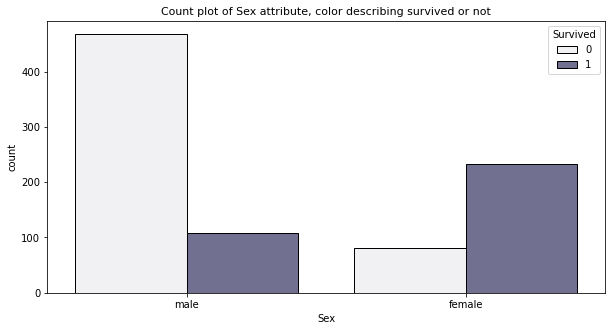

In [8]:
#Visualization of Sex column
plt.figure(figsize=(10,5))
plt.title("Count plot of Sex attribute, color describing survived or not", size=11)
sns.countplot(x='Sex', hue='Survived',data=df_train, color='#6E6B95', edgecolor='black')
plt.show()

Model best work with the numerical data, so it is essential to convert all categorical features into numerical. For same purpose we can use scikit-learn's OrdinalEncoder from preprocessing module.

In [9]:
for dataset in df:
    ordinal_encoder_sex = OrdinalEncoder()
    dataset['Sex'] = ordinal_encoder_sex.fit_transform(dataset[['Sex']]).astype(int)

df_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S


In [10]:
print("Sex column's 0 is {} and 1 is {}".format(ordinal_encoder_sex.categories_[0][0],ordinal_encoder_sex.categories_[0][1] ))

Sex column's 0 is female and 1 is male


# 6. Age


Age has lot of missing values, to impute the missing data we can use median value of the Age column.

The problem with continuous numerical data is that ofte it has a skewed distribution, i.e some ages might be more frequent than others which can have adverse affect on the overall efficiency of the model. To avoid this we can use binning on continuous feature.

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


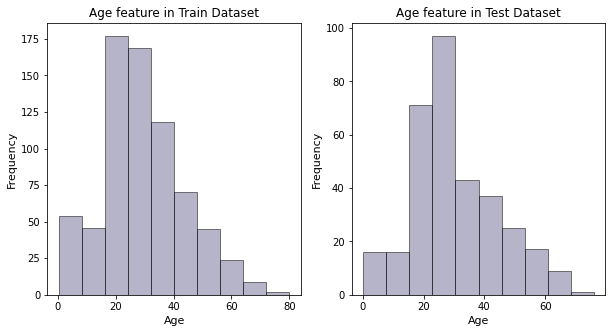

In [11]:
# Checking Age's distribution in the Titanic dataset

fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].set_title("Age feature in Train Dataset")  
axes[1].set_title("Age feature in Test Dataset")  

for (ax,dataset) in zip(axes.ravel(),df):
    x = dataset.loc[:, 'Age']
    ax.hist(x, alpha=0.5, color='#6E6B95', edgecolor='black')
    ax.set_xlabel('Age', size=11)
    ax.set_ylabel('Frequency', size=11)

Clearly from the histogram we can see that both training and test data have left skewed dataset, i.e low age value is more frequent.

We will try to use adaptive binning for age feature as it helps in avoiding ending up non uniform bins. Quartile based binning is a good starategy in age attribute.

In [12]:
# Quartile Binning
quartile_list = [0, 0.25, 0.5, 0.75, 1.0]

for dataset in df:
    quantiles = dataset['Age'].quantile(quartile_list)
    print(quantiles)

0.00     0.420
0.25    20.125
0.50    28.000
0.75    38.000
1.00    80.000
Name: Age, dtype: float64
0.00     0.17
0.25    21.00
0.50    27.00
0.75    39.00
1.00    76.00
Name: Age, dtype: float64


In [13]:

quartile_label = ['1st_Q', '2nd_Q', '3rd_Q', '4th_Q']
for dataset in df:
  simple_imputer = SimpleImputer(strategy='median')
  dataset['Age'] = simple_imputer.fit_transform(dataset[['Age']])

#Binning of the age attribute into quartiles
df_train['Age'] = pd.cut(df_train['Age'], bins=[0.40, 20.125, 28.0, 38.0, 80.0], labels=quartile_label)
df_test['Age'] = pd.cut(df_test['Age'], bins=[0.10, 21.0, 27.0, 39.0, 76.0], labels=quartile_label)

In [14]:
#converting categorical Age feature into discrete data using Ordinal Encoder

for dataset in df:
  ordinal_encoder_age = OrdinalEncoder()
  dataset['Age'] = ordinal_encoder_age.fit_transform(dataset[['Age']]).astype(int)
#Need to change
print("Age column's discrete value {} is 1st_Q, {} is 2nd_Q, {} is 3rd_Q and {} is 4th_Q ".format(ordinal_encoder_age.categories_[0][0],ordinal_encoder_age.categories_[0][1],
      ordinal_encoder_age.categories_[0][2], ordinal_encoder_age.categories_[0][3]))

Age column's discrete value 1st_Q is 1st_Q, 2nd_Q is 2nd_Q, 3rd_Q is 3rd_Q and 4th_Q is 4th_Q 


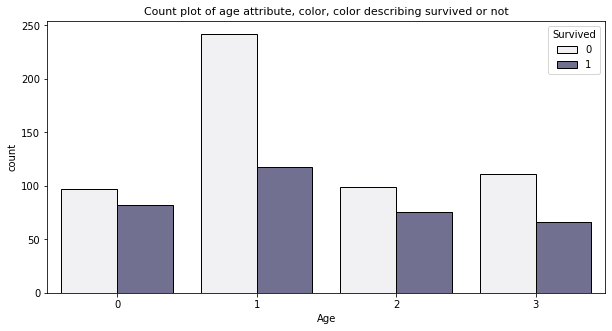

In [15]:
# Visualization of Binned Age
plt.figure(figsize=(10,5))
plt.title('Count plot of age attribute, color, color describing survived or not', size=11)
sns.countplot(data=df_train, x='Age', hue='Survived', color='#6E6B95', edgecolor='black')

# 7. SibSp and Parch


SibSp column describes the number of sibling and spouse onboarded the Tianic ship. SipSp attribute can be coupled with the Parch of the dataset which tells about the number of parents and childrens

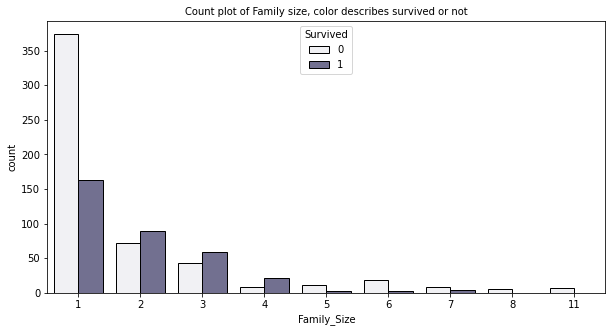

In [16]:
for dataset in df:
  dataset['Family_Size'] = dataset['SibSp'] + dataset['Parch'] + 1

plt.figure(figsize=(10,5))
plt.title("Count plot of Family size, color describes survived or not", size=10)
sns.countplot(data=df_train, x='Family_Size', hue='Survived', color='#6E6B95', edgecolor='black')

The family size with value 1 has significant higher value then other family size, we can further investigate family size with one.

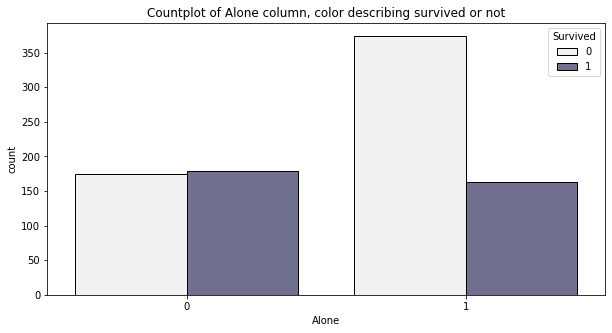

In [17]:
for dataset in df:
  dataset['Alone'] = 0
  dataset.loc[dataset['Family_Size']==1, 'Alone'] = 1
plt.figure(figsize=(10,5))
plt.title('Countplot of Alone column, color describing survived or not')
sns.countplot(data=df_train, x='Alone', hue='Survived', color='#6E6B95', edgecolor='black')

# 9. Fare 


Fare column of the dataset has some missing value , first we have to impute those values. We will also use binning for the the same feature.

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


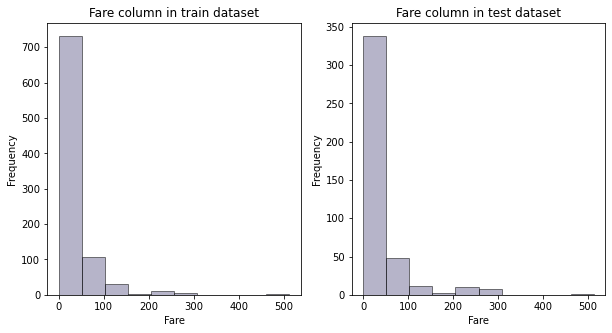

In [18]:
# Checking Fare attribute's distribution over the test and train dataset

fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].set_title('Fare column in train dataset')
axes[1].set_title('Fare column in test dataset')
for axs,dataset in zip(axes.ravel(), df):
  x = dataset.loc[:,'Fare']
  axs.hist(x, alpha=0.5,  color='#6E6B95', edgecolor='black')
  axs.set_xlabel('Fare')
  axs.set_ylabel('Frequency')

In [19]:
quartile_list_fare = [0, 0.25, 0.50, 0.75, 1.0]
for dataset in df:
  quantile_fare = dataset[['Fare']].quantile(quartile_list_fare)
  print(quantile_fare)

          Fare
0.00    0.0000
0.25    7.9104
0.50   14.4542
0.75   31.0000
1.00  512.3292
          Fare
0.00    0.0000
0.25    7.8958
0.50   14.4542
0.75   31.5000
1.00  512.3292


We can infer from the quartile values that below 50 percentile of the whole population paid less than 15 dollar for ride, so fare attribute has skewed characteristic

We will use adaptive binning same as age for the fare attribute.

In [20]:
for dataset in df:
  simple_imputer_fare = SimpleImputer(strategy='median')
  dataset['Fare'] = simple_imputer_fare.fit_transform(dataset[['Fare']])


In [21]:
#Binning fare attribute into quartile
quartile_range_fare = ['1st_Q', '2nd_Q', '3rd_Q', '4th_Q']
df_train['Fare'] = pd.cut(df_train['Fare'], bins=[-1.0, 7.91, 14.45, 31.0, 512.33], labels=quartile_range_fare)
df_test['Fare'] = pd.cut(df_test['Fare'], bins=[-1.0, 7.89, 14.45, 31.47, 512.33], labels=quartile_range_fare)

df_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,Alone
0,1,0,3,"Braund, Mr. Owen Harris",1,1,1,0,A/5 21171,1st_Q,NaN,S,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,PC 17599,4th_Q,C85,C,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,1,0,0,STON/O2. 3101282,2nd_Q,NaN,S,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,2,1,0,113803,4th_Q,C123,S,2,0
4,5,0,3,"Allen, Mr. William Henry",1,2,0,0,373450,2nd_Q,NaN,S,1,1


In [22]:
# Converting Fare categorical attribute into discrete numerical value
for dataset in df:
  ordinal_encoder_fare = OrdinalEncoder()
  dataset['Fare'] = ordinal_encoder_fare.fit_transform(dataset[['Fare']]).astype(int)

# 10. Cabin

# 11. Embarked

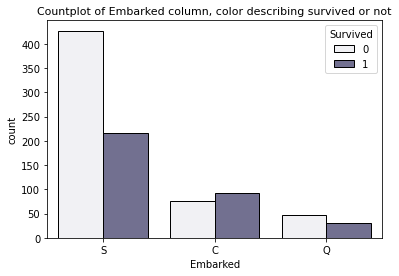

In [23]:
plt.title('Countplot of Embarked column, color describing survived or not', size=11)
sns.countplot(data=df_train, x='Embarked', hue='Survived', color='#6E6B95', edgecolor='black')

We can clearly infer that embarkation point 'S' is the most frequent one, so we can impute the missing values with most frequesnt embarkation point 

In [24]:
for dataset in df:
  dataset['Embarked'] = dataset['Embarked'].fillna('S')

  # Converting Categorical Embarked Feature into Discrete numerical
  ordinal_encoder_embarked = OrdinalEncoder()
  dataset['Embarked'] = ordinal_encoder_embarked.fit_transform(dataset[['Embarked']]).astype(int)

**We have converted all relevant categorical features into discrete numerical values, now our  dataset is ready as an input for the model pipeline**

In [25]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  891 non-null    int64 
 1   Survived     891 non-null    int64 
 2   Pclass       891 non-null    int64 
 3   Name         891 non-null    object
 4   Sex          891 non-null    int64 
 5   Age          891 non-null    int64 
 6   SibSp        891 non-null    int64 
 7   Parch        891 non-null    int64 
 8   Ticket       891 non-null    object
 9   Fare         891 non-null    int64 
 10  Cabin        204 non-null    object
 11  Embarked     891 non-null    int64 
 12  Family_Size  891 non-null    int64 
 13  Alone        891 non-null    int64 
dtypes: int64(11), object(3)
memory usage: 97.6+ KB


# Feature Selection & Data Visualization 

In [26]:
drop_element = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
df_train = df_train.drop(drop_element, axis=1)
df_test = df_test.drop(drop_element, axis=1)

In [27]:
df_train.head(2)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Family_Size,Alone
0,0,3,1,1,0,0,2,2,0
1,1,1,0,2,0,3,0,2,0


In [28]:
df_test.head(2)

,Pclass,Sex,Age,Parch,Fare,Embarked,Family_Size,Alone
0,3,1,2,0,0,1,1,1
1,3,0,3,0,0,2,2,0


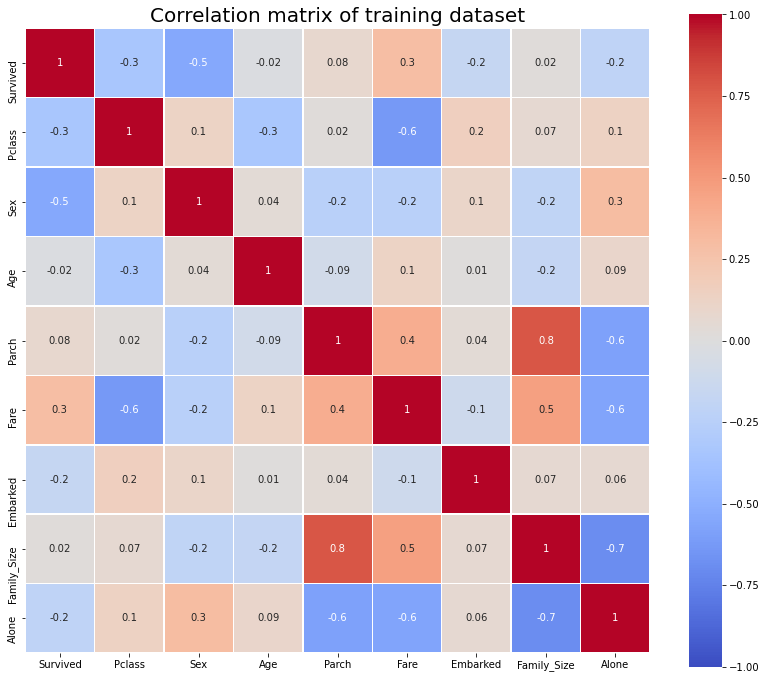

In [29]:
# Correlation Rectangular Matrix
plt.figure(figsize=(14,12))
plt.title("Correlation matrix of training dataset", size=20)
sns.heatmap(df_train.corr(), annot=True, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap='coolwarm', linewidth=0.5, linecolor='white', square=True)

The important conclusion from the correlation matrix is that none of the features are related to each other, i.e there is none redundant feature in the train dataset.

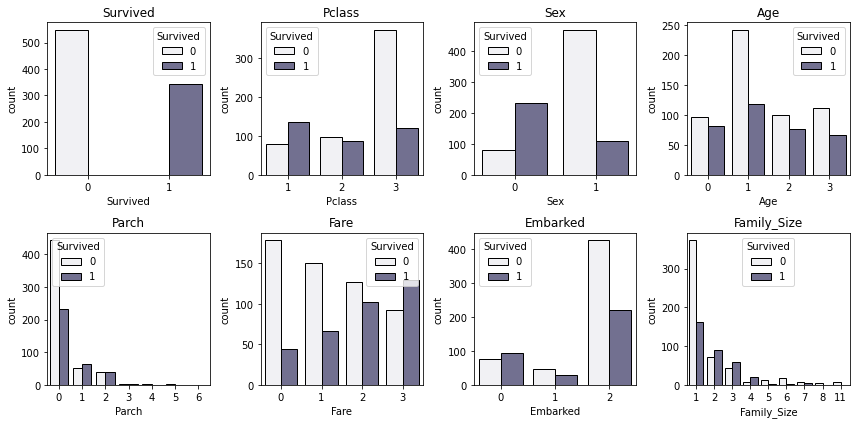

In [30]:
# Visualizing Numerical data
numeric_data = ['Survived', 'Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked', 'Family_Size']
n_cols =4
n_rows =2
fig, ax = plt.subplots(n_rows, n_cols, figsize= (n_cols*3, n_rows*3))
for r in range(n_rows):
  for c in range(n_cols):
    i = r*n_cols + c
    axs = ax[r][c]
    sns.countplot(df_train[numeric_data[i]], hue=df_train['Survived'], ax=axs, color='#6E6B95', edgecolor='black')
    axs.set_title(numeric_data[i])
    axs.legend(title = 'Survived', loc ='best')
plt.tight_layout()

In [31]:
y = df_train[['Survived']]
X = df_train.drop('Survived', axis=1)

#Spliting Dataset into X_train and X_validation 
X_train, X_val, y_train, y_val = train_test_split(X,y, random_state=SEED, train_size=0.8)
X_train.shape

(712, 8)

In [32]:
# Defining Grid Search CV function 

kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)

def grid_search(X, y, estimator, params, random_state=SEED, score='accuracy', n_jobs=-1,
                cv=kfold):
  """
  Grid search to figure out best parameters using 'cv' fold cross validation
  and utilising all available cores.
  """
  print("Hyper paramter tuning for {} by grid search".format(score))

  clf = GridSearchCV(estimator=estimator, param_grid=params, n_jobs=n_jobs, cv=kfold, scoring=score)
  clf.fit(X,y)

  print('Best parameters by grid search: \n', clf.best_params_)
  return clf

In [33]:
def plot_learning_curve(estimator, X, y, cv=kfold, train_sizes=np.linspace(0.1, 1.0, 5)):
  """
  Plot test and traning curves

  """
 
 
  plt.title('Learning Curve')
  plt.xlabel("Training Examples")
  plt.ylabel("Score")

  train_sizes, train_scores, test_scores, _, _ = learning_curve(estimator, X,y, cv=cv, n_jobs=-1, train_sizes=train_sizes, return_times=True)
  # train score mean and std
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)

  # test score mean and std
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)

  #Plotting Learning Curves
  plt.grid()

  plt.fill_between(train_sizes, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std, alpha=0.1, color='r')
  plt.fill_between(train_sizes, test_scores_mean-test_scores_std, test_scores_mean+ test_scores_std, alpha=0.1, color='g')
  plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training_Score')
  plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross_Validation_Score')
  plt.legend(loc='best')

  return plt

# 1. Random Forest

In [34]:
# Instantiate Random Forest classifier 
random_forest_clf = RandomForestClassifier(random_state=SEED)
random_forest_clf.get_params()


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [35]:
# parameter grid
params= {
    'bootstrap': [True, False],
    'max_depth': [int(x) for x in range(10,110,50)],
    'max_features': ['auto', 'sqrt'],
    'min_samples_split': [2,4,6]
}

In [36]:
random_forest_clf_hypertuned = grid_search(X_train, y_train, estimator=random_forest_clf, params= params)


Hyper paramter tuning for accuracy by grid search


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best parameters by grid search: 
 {'bootstrap': True, 'max_depth': 60, 'max_features': 'auto', 'min_samples_split': 6}


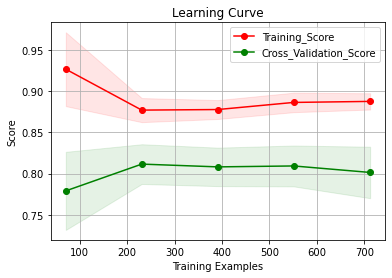

In [37]:
# Plotting learning curve for Random Forest Estimator
plot_learning_curve(random_forest_clf_hypertuned, X, y, cv=kfold, train_sizes=np.linspace(0.1, 1.0, 5))
plt.show()

In [38]:
# prediction using Random Forest estimator on validation dataset

y_predict = random_forest_clf_hypertuned.predict(X_val)

accuracy_rf = accuracy_score(y_val, y_predict)
print("The accuracy score for Random Forest Classifier is {:.4f}".format(accuracy_rf))

The accuracy score for Random Forest Classifier is 0.8212


# 2. Decision Tree

In [39]:
from sklearn.tree import DecisionTreeClassifier
decision_tree_clf = DecisionTreeClassifier(random_state=SEED)

decision_tree_clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 42,
 'splitter': 'best'}

In [40]:
# Hyper tuning for Decision Tree classifier
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(1,16)),
    'min_samples_leaf': list(range(1,10))
}

In [41]:
decision_tree_hypertuned = grid_search(X_train, y_train, decision_tree_clf, params, random_state=SEED, score='accuracy', n_jobs=-1,
                cv=kfold)

Hyper paramter tuning for accuracy by grid search
Best parameters by grid search: 
 {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 9}


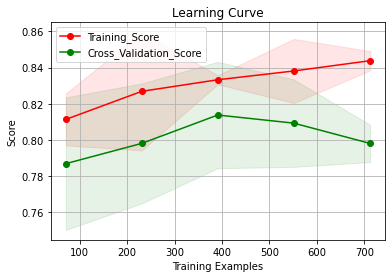

In [42]:
plot_learning_curve(decision_tree_hypertuned, X, y, cv=kfold, train_sizes=np.linspace(0.1, 1.0, 5))
plt.show()

In [43]:
# prediction using SVM estimator on validation dataset

y_predict = decision_tree_hypertuned.predict(X_val)
accuracy_decision_tree = accuracy_score(y_val, y_predict)
print("The accuracy score for SVM is {:.4f}".format(accuracy_decision_tree))

The accuracy score for SVM is 0.7933


# 3. K NearestNeighbor

In [44]:
K_neigh_clf = KNeighborsClassifier()

K_neigh_clf.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [45]:
# Hyper parameter tuning

params = {
    'leaf_size': list(range(1,20)),
    'n_neighbors': list(range(1,10)),
    'p': [1,2]
}

In [46]:
k_neigh_hypertuned = grid_search(X_train, y_train, K_neigh_clf, params, random_state=SEED, score='accuracy', n_jobs=-1,
                cv=kfold)

Hyper paramter tuning for accuracy by grid search
Best parameters by grid search: 
 {'leaf_size': 18, 'n_neighbors': 7, 'p': 1}


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


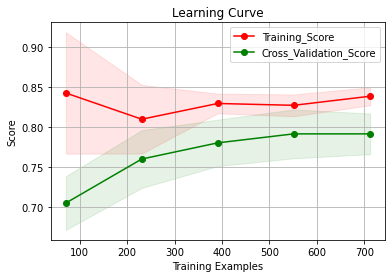

In [47]:
plot_learning_curve(k_neigh_hypertuned, X, y, cv=kfold, train_sizes=np.linspace(0.1, 1.0, 5))
plt.show()

In [48]:
# prediction using KNeighbors estimator on validation dataset

y_predict = k_neigh_hypertuned.predict(X_val)
accuracy_k_neighbors= accuracy_score(y_val, y_predict)
print("The accuracy score for KNN is {:.4f}".format(accuracy_k_neighbors))

The accuracy score for KNN is 0.7933


# 4. Naive Bayes 

In [49]:
naive_bayes_clf = GaussianNB()

naive_bayes_clf.get_params()

{'priors': None, 'var_smoothing': 1e-09}

In [50]:
params = {
    'var_smoothing': [np.exp(-i) for i in range(1,10)]
}

In [51]:
naive_bayes_hypertuned = grid_search(X_train, y_train, naive_bayes_clf, params, random_state=SEED, score='accuracy', n_jobs=-1,
                cv=kfold)

Hyper paramter tuning for accuracy by grid search
Best parameters by grid search: 
 {'var_smoothing': 0.006737946999085467}


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


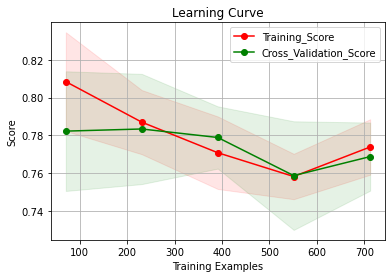

In [52]:
plot_learning_curve(naive_bayes_hypertuned, X, y, cv=kfold, train_sizes=np.linspace(0.1, 1.0, 5))
plt.show()

In [53]:
# prediction using Naive Bayes estimator on validation dataset

y_predict = naive_bayes_hypertuned.predict(X_val)
accuracy_naive_bayes= accuracy_score(y_val, y_predict)
print("The accuracy score for KNN is {:.4f}".format(accuracy_naive_bayes))

The accuracy score for KNN is 0.7765


# 5. Support Vector Machine

In [54]:
svm_clf = SVC(random_state=SEED, probability=True)
svm_clf.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [55]:
# Hyper parameter tuning for SVM parameters
params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear'],
    'gamma': [0.001, 0.01, 0.1, 1, 10, 100]    
}

In [56]:
svm_grid_hypertuned = grid_search(X_train, y_train, svm_clf, params, random_state=SEED, score='accuracy', n_jobs=-1,
                cv=kfold)

Hyper paramter tuning for accuracy by grid search
Best parameters by grid search: 
 {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


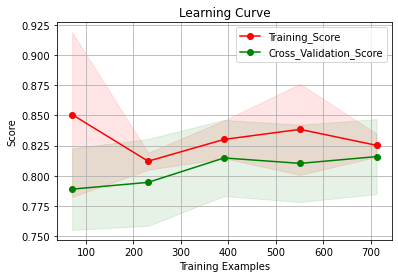

In [57]:
plot_learning_curve(svm_grid_hypertuned, X, y, cv=kfold, train_sizes=np.linspace(0.1, 1.0, 5))
plt.show()

In [58]:
# prediction using SVM estimator on validation dataset

y_predict = svm_grid_hypertuned.predict(X_val)

accuracy_svm = accuracy_score(y_val, y_predict)
print("The accuracy score for SVM is {:.4f}".format(accuracy_svm))

The accuracy score for SVM is 0.8156


# **Conclusion**

In [59]:
accuracy_dataframe = pd.DataFrame({
    'Models': ['SVM', 'Decision Tree', 'KNN', 'Naive Bayes', 'Random Forest'],
    'Accuracy': [accuracy_svm, accuracy_decision_tree, accuracy_k_neighbors, accuracy_naive_bayes,accuracy_rf ]
})

accuracy_df_sorted = accuracy_dataframe.sort_values(by='Accuracy', ascending=False)

accuracy_df_sorted.head()

,Models,Accuracy
4,Random Forest,0.821229
0,SVM,0.815642
1,Decision Tree,0.793296
2,KNN,0.793296
3,Naive Bayes,0.776536


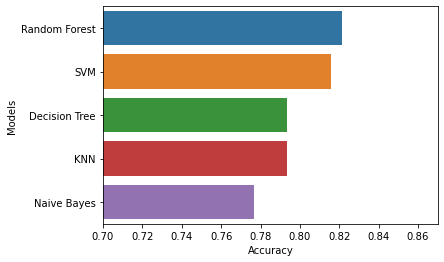

In [60]:
ax = sns.barplot(data =accuracy_df_sorted, y= 'Models', x= 'Accuracy' )
ax.set(ylabel='Models', xlim = (0.7, 0.87))
plt.show()

# Ensemble Learning

We have already used Random Forest, Support Vector Machine, Naive Bayes, Decision Tree and K Nearest Neighbors estimators to fit and predict the output for the test dataset and each of them is achieving test accuracy more than 70%. A simple way yo create a better classifier is to aggregate the predictions of each classifier and predict the class that gets the most vote. 

All classifiers are able to estimate class probabilities (i.e they all have predict_proba() method ), so we can predict the class with the heighest class probability, averaged over all the individual clssifier called as soft voting. 

In [61]:

voting = VotingClassifier(
    estimators=[('svm', svm_grid_hypertuned),
                ('dt',decision_tree_hypertuned ),
                ('knn', k_neigh_hypertuned),
               ('rf',random_forest_clf_hypertuned ),
               ('nb', naive_bayes_hypertuned )],
    voting='soft',
    n_jobs=-1
)

voting = voting.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [62]:
print(voting)

VotingClassifier(estimators=[('svm',
                              GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                                           estimator=SVC(probability=True,
                                                         random_state=42),
                                           n_jobs=-1,
                                           param_grid={'C': [0.001, 0.01, 0.1,
                                                             1, 10, 100],
                                                       'gamma': [0.001, 0.01,
                                                                 0.1, 1, 10,
                                                                 100],
                                                       'kernel': ['rbf',
                                                                  'linear']},
                                           scoring='accuracy')),
                             ('dt',
                              Gr

In [63]:
y_pred = voting.predict(X_val)

voting_accuracy = accuracy_score(y_val, y_pred)
print('Accuracy of ensemble method: {:.4f}'.format(voting_accuracy))

Accuracy of ensemble method: 0.8101


In [64]:
best_model = voting

predictions = best_model.predict(df_test)

kaggle_submission_output = pd.DataFrame ({'PassengerId': df_test_copy['PassengerId'], 'Survived':predictions })
kaggle_submission_output.to_csv ('Titanic_final_submission.csv', index=False)

print('Output saved Successfully')

Output saved Successfully
